use the spread 2Y and spread 5Y of swaps and take zscore of 1Y  
then take average between the 2 signals

# Imports

In [392]:
import sys
sys.path.insert(1, '../')
from genesis import *

if not sys.warnoptions: 
    import warnings
    warnings.simplefilter("ignore")

In [393]:
# Asia FX
total_returns = total_returns_usd[ASIA_FX]
spot_returns = spot_returns_usd[ASIA_FX]
carry_returns = carry_returns_usd[ASIA_FX]

# Settings

In [394]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=130,
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=130,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=260)

# Other Data

In [395]:
swaps = pd.read_csv("/Users/Gaby/Downloads/Code_Dymon/swaps.csv", index_col=0).iloc[2:]

In [396]:
swaps.columns = ["2Y", "5Y"]
swaps = swaps.astype(float)
swaps.index = pd.to_datetime(swaps.index)

In [397]:
spread_2y = swaps["2Y"]
spread_5y = swaps["5Y"]
spread_2y.index.name = "date"
spread_5y.index.name = "date"

# Signal

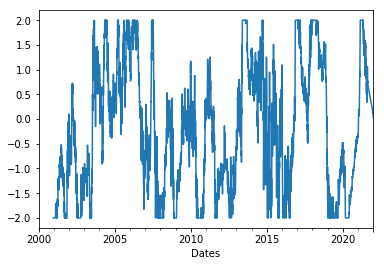

In [398]:
spread_5y.pipe(fill_date, True).pipe(omit_trailing_na).pipe(zscore, 252).pipe(cap_helper, 2).plot()

In [399]:
signal1 = spread_5y.pipe(fill_date, True).pipe(omit_trailing_na).pipe(zscore, 252).pipe(cap_helper, 2)
signal2 = spread_2y.pipe(fill_date, True).pipe(omit_trailing_na).pipe(zscore, 252).pipe(cap_helper, 2)
signal = (signal1 + signal2)/2
signal = signal.pipe(rolling_mean, 5)
# signal.plot()
sig = pd.concat([signal] * len(total_returns.columns), axis=1)
sig.columns = total_returns.columns
sig.index = pd.to_datetime(sig.index)

In [400]:
b = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = settings)
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [401]:
bt_obj = b

In [402]:
get_summary(bt_obj)

Returns   : 0.07832287321789279
Vol       : 0.10961043492694207
SR        : 0.7145567232727141
Max DD    : -32.48
Hit rate  : 0.509
W | N | L : 0.51 | 0.0 | 0.49
W/L Ratio : 1.04


In [403]:
get_returns_stats(bt_obj.asset_rtn.loc["2003":], b.wts.loc["2003":])

,USDSGD,USDTHB,USDTWD,USDKRW,USDPHP,USDINR,USDIDR,USDMYR,USDCNH
annualized_return,0.74687,1.78372,0.897936,-0.270443,0.427915,1.2151,0.965534,1.00756,0.413792
sharpe,0.390872,0.948388,0.460925,-0.14275,0.230662,0.625188,0.461167,0.586061,0.359217
dollar_sharpe,0.393488,0.95705,0.457302,-0.158645,0.232485,0.588839,0.454183,0.595019,0.357224
trade_sharpe,0.390872,0.948388,0.460925,-0.14275,0.230662,0.625188,0.461167,0.586061,0.359217
long_sharpe,-0.0356249,-0.092469,0.582854,-0.454452,-0.584577,0.513137,0.161584,0.329436,-0.0775554
short_sharpe,0.737075,1.73908,0.360603,0.0897843,0.998004,0.730856,0.773154,0.866088,1.26977
sortino,0.255414,0.641157,0.311655,-0.0865194,0.147329,0.41234,0.292293,0.342198,0.133618
max_drawdown,-5.82563,-5.24053,-4.37579,-13.4687,-11.611,-6.36895,-5.45118,-5.83598,-5.12618
max_drawdown_start,2005-11-14,2005-07-20,2011-02-24,2004-05-10,2003-05-12,2010-11-05,2005-08-29,2005-12-30,2013-05-31
max_drawdown_end,2007-07-24,2006-05-01,2011-09-22,2011-09-22,2006-04-04,2011-12-14,2006-05-08,2006-05-10,2015-08-10


In [404]:
def plot_bt(bt_obj):
  gs = GridSpec(nrows = 4, ncols = 3)
  fig = plt.figure(figsize=(30, 30))
  fig.suptitle(t="Full Backtest", fontsize=30, y=.925)

  fig.add_subplot(gs[0]).set_label(gen_plot_rtn(bt_obj.model_rtn, main = "Returns (Full Period)"))
  fig.add_subplot(gs[1]).set_label(gen_plot_rtn(bt_obj.model_rtn["2012":], main = "Returns (2012/)"))
  fig.add_subplot(gs[2]).set_label(gen_rtn_asset(bt_obj))

  fig.add_subplot(gs[3]).set_label(pf.plot_drawdown_underwater(bt_obj.model_rtn))
  fig.add_subplot(gs[4]).set_label(gen_rtn_component(bt_obj, spot_returns.loc[:"2016-12-31"], carry_returns.loc[:"2016-12-31"]))
  fig.add_subplot(gs[5]).set_label(gen_rtn_longshort(bt_obj))

  fig.add_subplot(gs[6]).set_label(gen_leadlag(bt_obj, nlag=10))
  fig.add_subplot(gs[7]).set_label(gen_rolling_winloss(bt_obj.model_rtn))
  fig.add_subplot(gs[8]).set_label(gen_rolling_hitrate(bt_obj.model_rtn))

  fig.add_subplot(gs[9]).set_label(pf.plot_annual_returns(bt_obj.model_rtn))
  fig.add_subplot(gs[10:]).set_label(gen_signal(bt_obj))

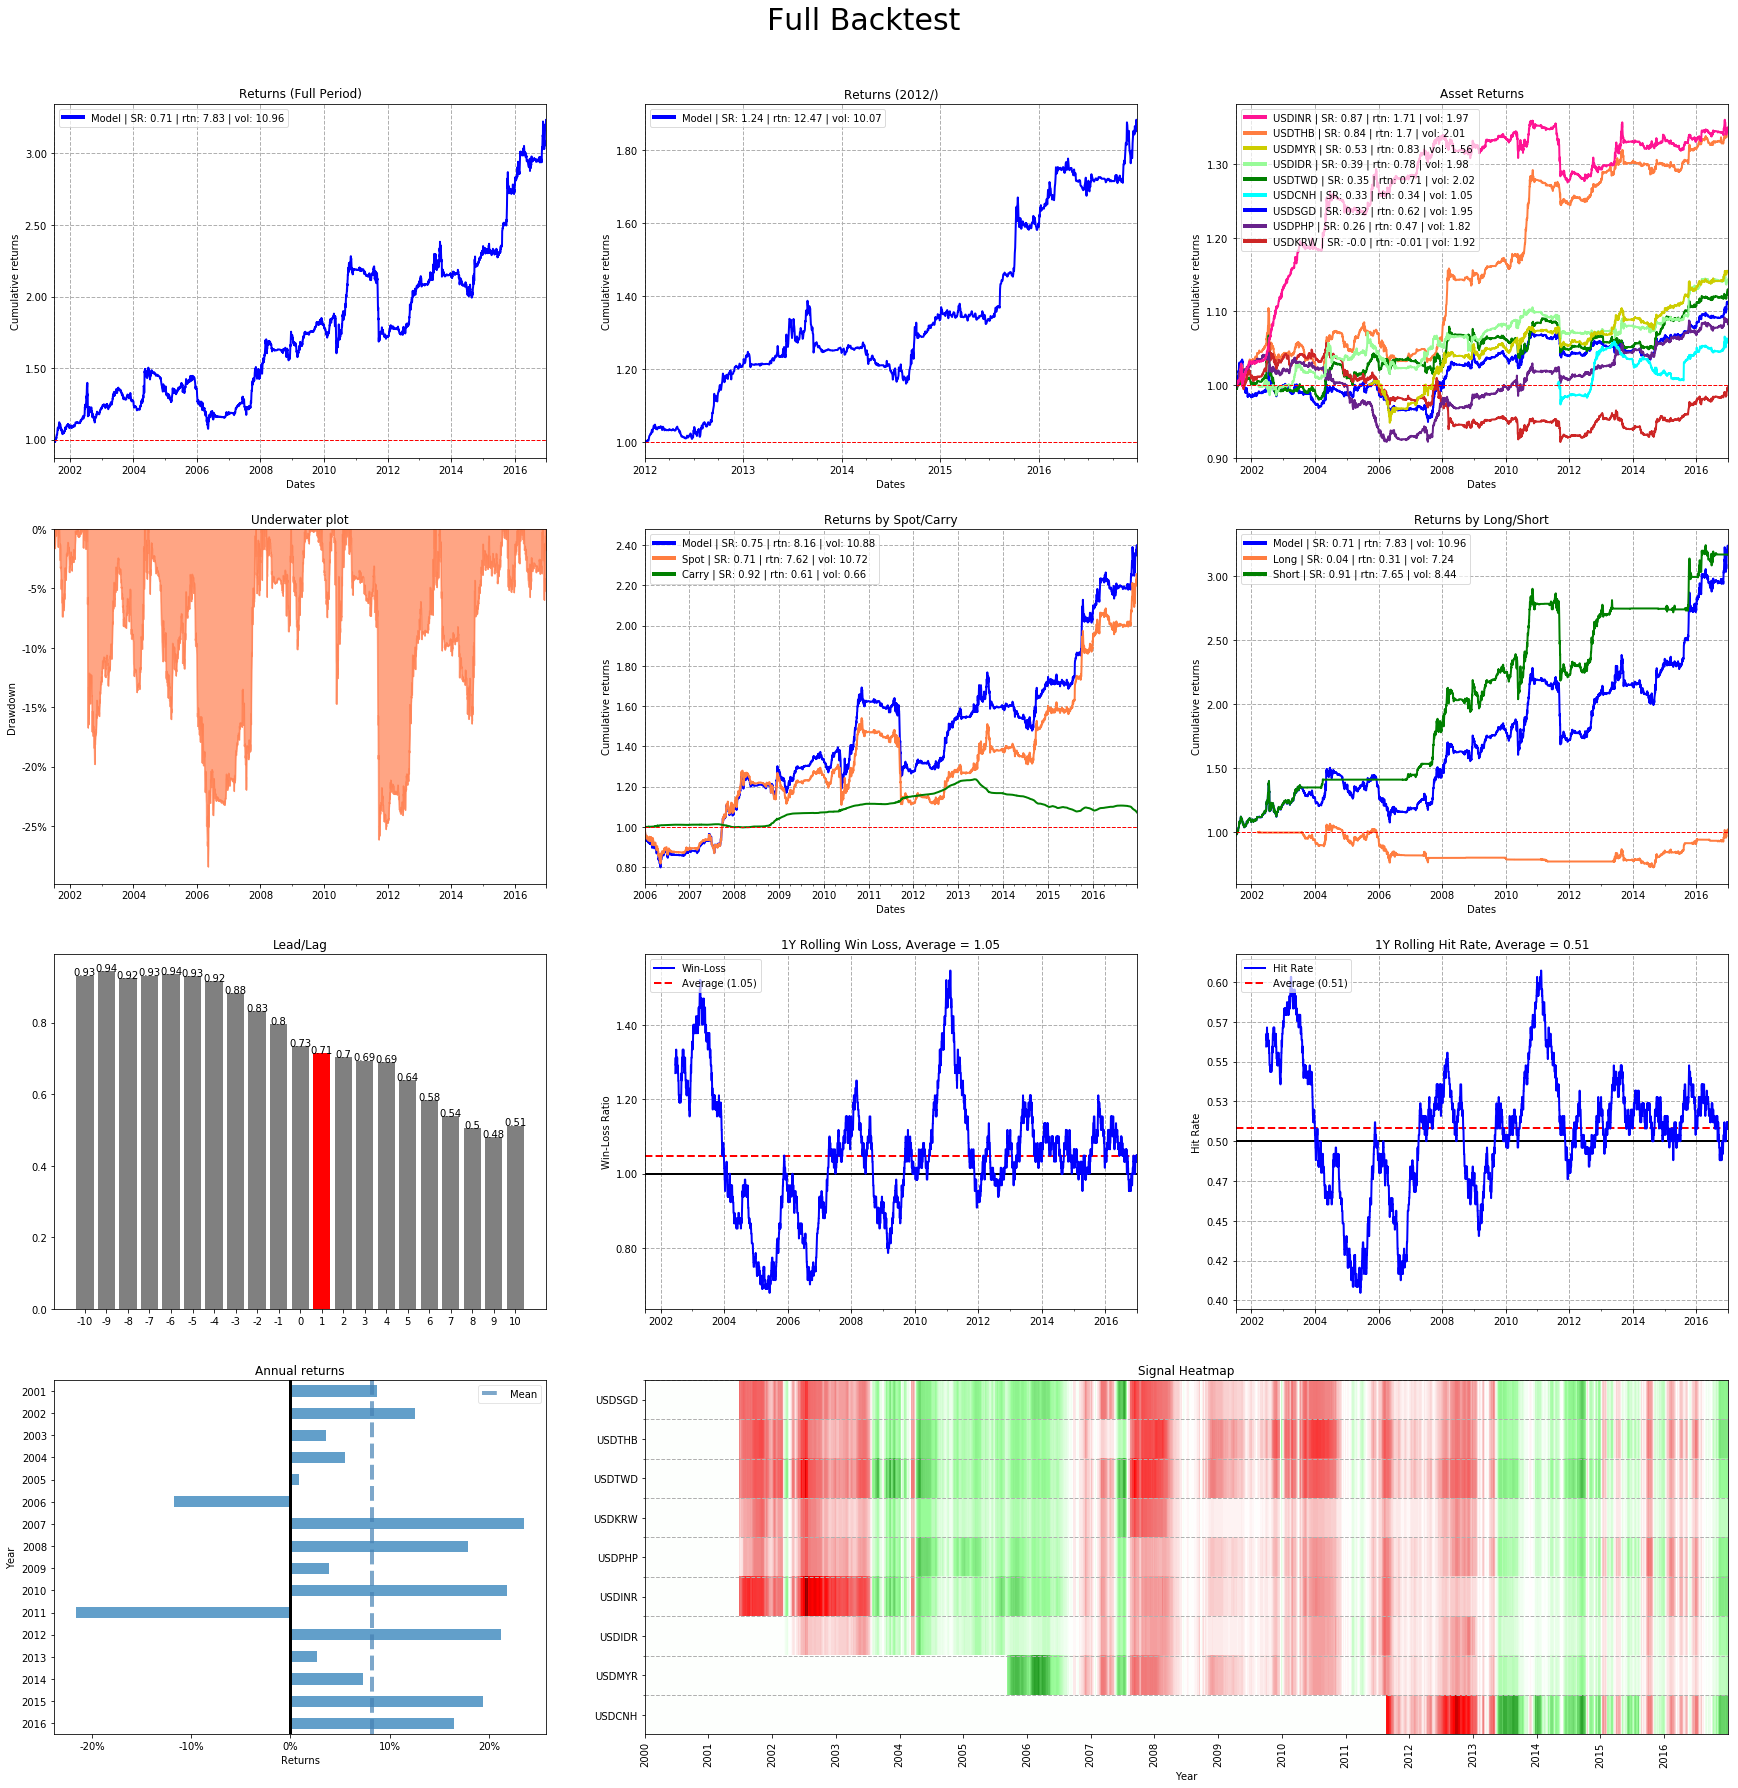

In [14]:
plot_bt(bt_obj)

In [ ]:
pf.plot_monthly_returns_heatmap(bt_obj.model_rtn)

In [ ]:
pf.plot_monthly_returns_dist(bt_obj.model_rtn)

In [19]:
# gs = GridSpec(nrows = 2, ncols = 2)
# fig = plt.figure(figsize=(20, 15))
# fig.suptitle(t="Full Backtest", fontsize=30, y=.925)

# fig.add_subplot(gs[0]).set_label(gen_plot_rtn(bt_obj.model_rtn, main = "Returns (Full Period)"))
# fig.add_subplot(gs[1]).set_label(gen_rtn_asset(bt_obj))
# fig.add_subplot(gs[2]).set_label(pf.plot_drawdown_underwater(bt_obj.model_rtn))
# fig.add_subplot(gs[3]).set_label(gen_rtn_longshort(bt_obj))

In [20]:
# gen_rtn_longshort(bt_obj)
# gen_rtn_component(bt_obj, spot_rtns, carry_rtns)
# gen_leadlag(b, nlag=20)
# gen_rolling_hitrate(bt_obj.model_rtn)
# gen_rolling_winloss(bt_obj.model_rtn)
# pf.plot_monthly_returns_dist(bt_obj.model_rtn)
# pf.plot_annual_returns(bt_obj.model_rtn)
# gen_signal(bt_obj)
# gen_rtn_asset(bt_obj)
# gen_plot_rtn(bt_obj.model_rtn["2012":])
# gen_rolling_sharpe(bt_obj.model_rtn)
# gen_rtn_col_component(bt_obj, spot_rtns, carry_rtns)
# gen_rtn_col_longshort(bt_obj)

In [ ]:
gen_rtn_col_component(bt_obj, spot_returns.loc[:"2016-12-31"], carry_returns.loc[:"2016-12-31"])

In [ ]:
gen_rtn_col_longshort(bt_obj)

# Regimes

## 1. GFC

Aug 2007 - April 2009

In [585]:
from datetime import datetime

regime1 = pd.DataFrame(bt_obj.model_rtn)
regime1['regime'] = np.where(regime1.index < datetime(2007,8,1), 'pre-GFC', 
                             np.where(regime1.index > datetime(2009,4,30), 'post-GFC','GFC'))
regime1 = regime1['regime']
regime1

Dates
2001-07-03     pre-GFC
2001-07-04     pre-GFC
2001-07-05     pre-GFC
2001-07-06     pre-GFC
2001-07-09     pre-GFC
                ...   
2016-12-26    post-GFC
2016-12-27    post-GFC
2016-12-28    post-GFC
2016-12-29    post-GFC
2016-12-30    post-GFC
Name: regime, Length: 4044, dtype: object

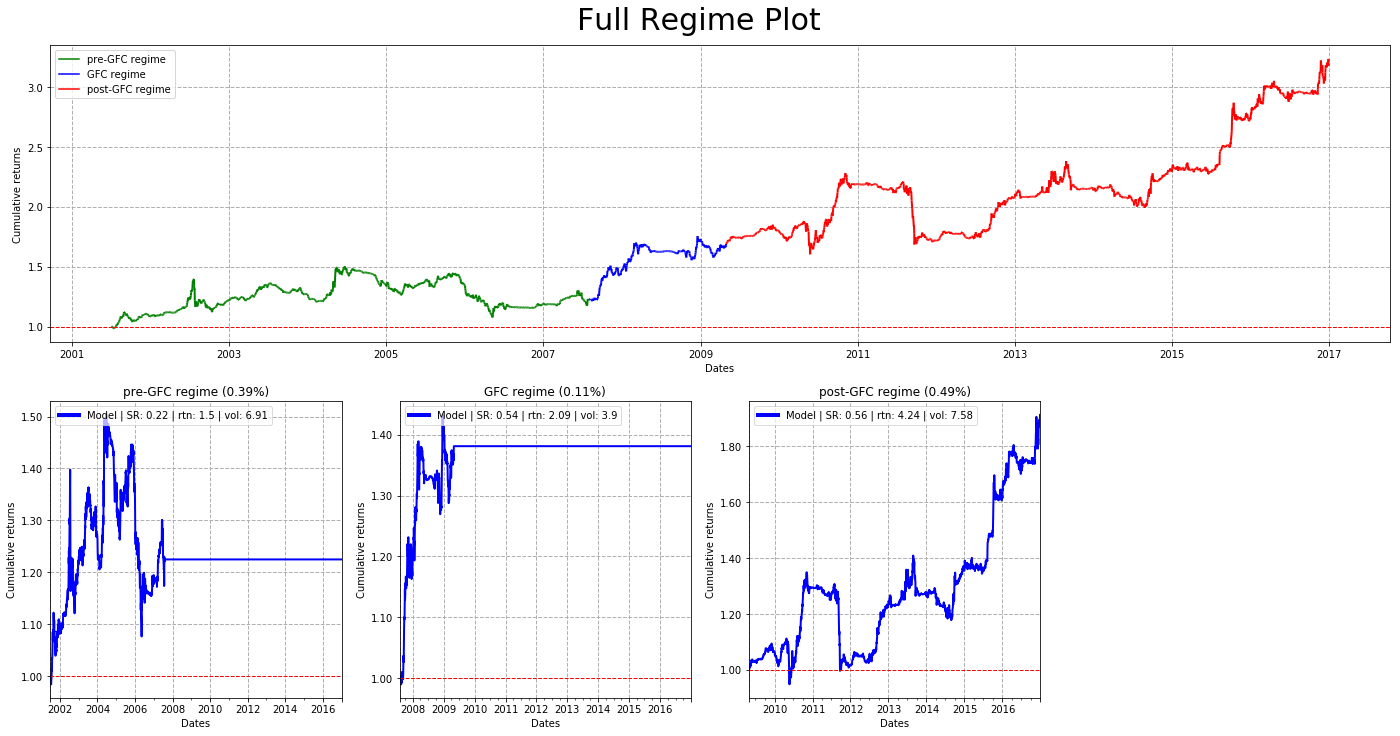

In [586]:
full_regime_plot(bt_obj,regime1)

## 2. Bull/bear & steep/flat

1. bull steep: larger spread between LT and ST interest rates, due to ST rates decreasing faster than LT rates
2. bear steep: larger spread between LT and ST interest rates, due to LT rates rising faster than ST rates
3. bull flat: smaller spread between LT and ST interest rates, due to ST rates increasing faster than LT rates
4. bear flat: smaller spread between LT and ST interest rates, due to LT rates decreasing faster than ST rates

In [645]:
regime2 = pd.read_csv("/Users/Gaby/Downloads/Code_Dymon/us_govs.csv").iloc[2:,[0,1,4]]

regime2.rename(columns={'ticker':'date'}, inplace=True)
regime2['date'] = pd.to_datetime(regime2['date'])
regime2.set_index('date', inplace=True)

regime2 = regime2.groupby(pd.Grouper(freq='M')).nth(0) #get month-end values 

regime2[["USGG3M Index", "USGG10Y Index"]] = regime2[["USGG3M Index", "USGG10Y Index"]].apply(pd.to_numeric)
regime2["10Y-3M"] = regime2["USGG10Y Index"]-regime2["USGG3M Index"]
regime2["3M_change"] = regime2['USGG3M Index'] - regime2['USGG3M Index'].shift(1)
regime2["10Y_change"] = regime2['USGG10Y Index'] - regime2['USGG10Y Index'].shift(1)

regime2['regime'] = np.where((regime2['10Y-3M'] > regime2['10Y-3M'].shift(1)) & (regime2["3M_change"] < 0) & (abs(regime2["3M_change"]) > regime2["10Y_change"]), "bull-steepening",
                    np.where((regime2['10Y-3M'] > regime2['10Y-3M'].shift(1)) & (regime2["10Y_change"] > 0) & (regime2["10Y_change"] > abs(regime2["3M_change"])), "bear-steepening",
                    np.where((regime2['10Y-3M'] < regime2['10Y-3M'].shift(1)) & (regime2["3M_change"] > 0) & (regime2["3M_change"] > abs(regime2["10Y_change"])), "bull-flattening",
                    np.where((regime2['10Y-3M'] < regime2['10Y-3M'].shift(1)) & (regime2["10Y_change"] < 0) & (abs(regime2["10Y_change"]) > regime2["3M_change"]), "bear-flattening",0))))

regime2 = pd.DataFrame(bt_obj.model_rtn).join(regime2)
regime2 = regime2['regime']
regime2 = regime2.fillna(method='bfill')
regime2 = regime2.fillna(method='ffill')

regime2

Dates
2001-07-03    bear-flattening
2001-07-04    bear-flattening
2001-07-05    bear-flattening
2001-07-06    bear-flattening
2001-07-09    bear-flattening
                   ...       
2016-12-26    bear-steepening
2016-12-27    bear-steepening
2016-12-28    bear-steepening
2016-12-29    bear-steepening
2016-12-30    bear-steepening
Name: regime, Length: 4044, dtype: object

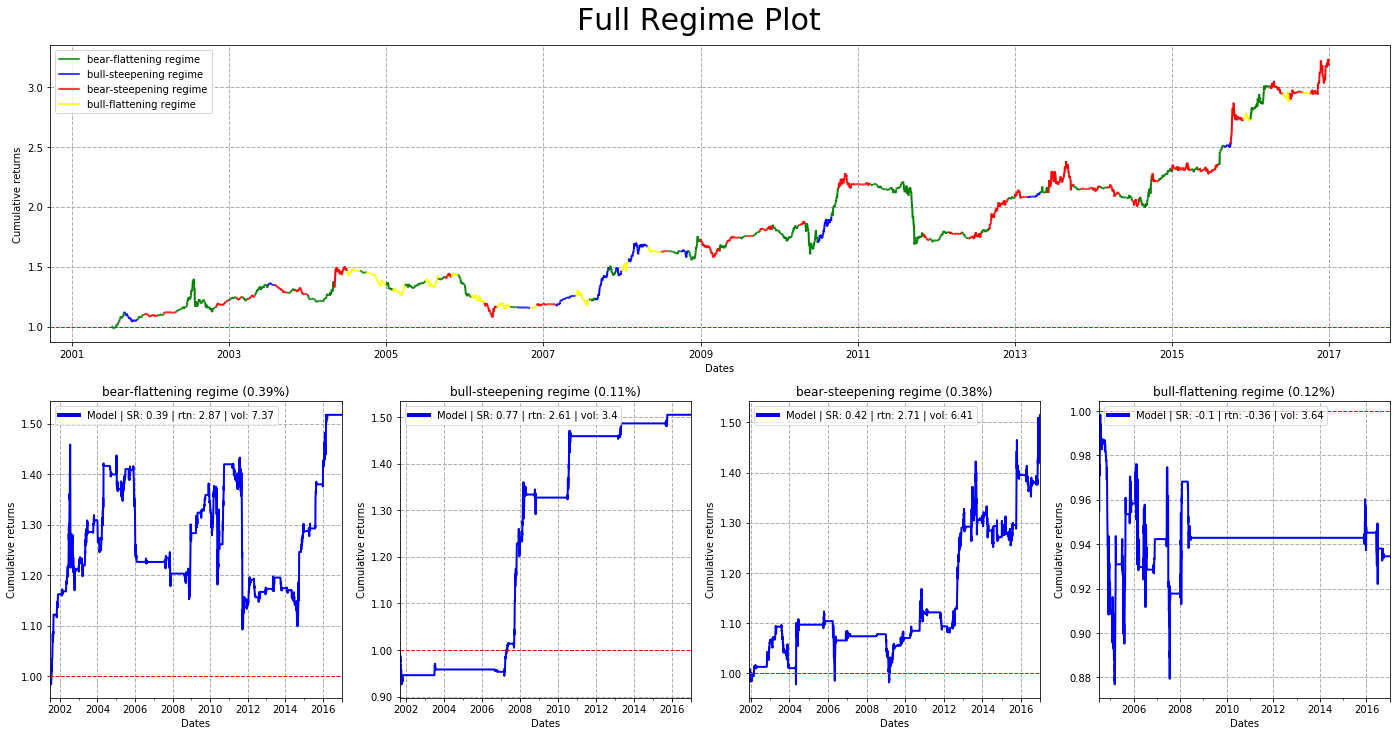

In [646]:
full_regime_plot(bt_obj,regime2)

## 3. Volatility cycle (VIX index)

The volatility cycle is linked to the VIX index. We consider that whenever the VIX is above its five-year moving average, markets are in a high-volatility regime and vice versa (Societe Generale: Fixed Income Risk Premia - Time for Some Carry)

VIX cycle data: https://fred.stlouisfed.org/series/VIXCLS 

In [647]:
vix = pd.read_csv("/Users/Gaby/Downloads/VIXCLS.csv", index_col=0)
vix = vix[vix.VIXCLS != "."]
vix = vix.astype({"VIXCLS": float})

vix['5Y_MA'] = vix.rolling(window=1260).mean()
vix['regime'] = np.where(vix['VIXCLS'] > vix['5Y_MA'], "high-volatility", "low-volatility")

regime3 = pd.DataFrame(bt_obj.model_rtn).join(vix)
regime3 = regime3.fillna(method='ffill')
regime3 = regime3['regime']
regime3

Dates
2001-07-03    low-volatility
2001-07-04    low-volatility
2001-07-05    low-volatility
2001-07-06    low-volatility
2001-07-09    low-volatility
                   ...      
2016-12-26    low-volatility
2016-12-27    low-volatility
2016-12-28    low-volatility
2016-12-29    low-volatility
2016-12-30    low-volatility
Name: regime, Length: 4044, dtype: object

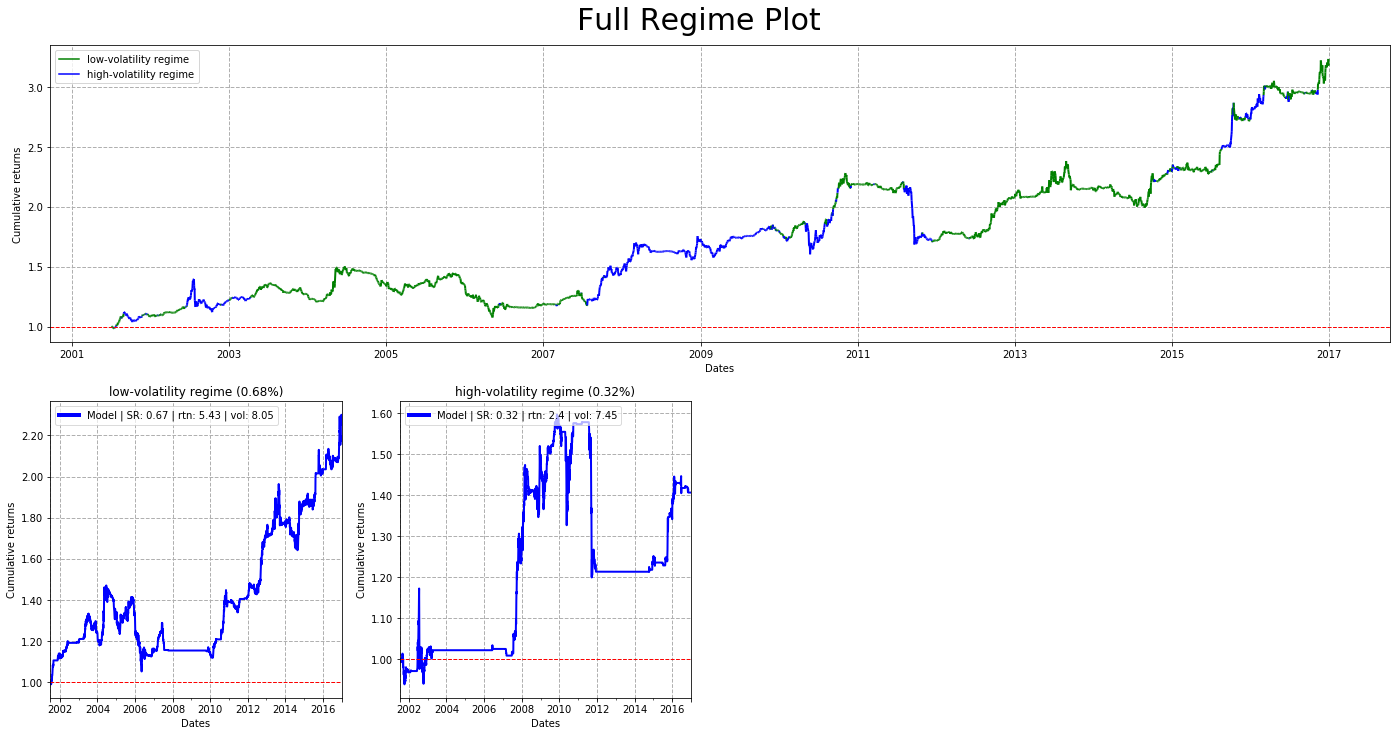

In [475]:
full_regime_plot(bt_obj, regime3)

## 4. Economic cycle (OECD Composite Leading Indicator)

Using the indicator’s absolute value and direction of change, we divide the past into four distinct periods  based on the value of the OECD indicator: expansion, downturn, slowdown and recovery.

1. When the indicator is increasing and above 100, the economy in expansion; 
2. when the indicator is  decreasing and above 100, the economy is in a downturn; 
3. when the indicator is decreasing and below 100, the economy is slowing down; 
4. and when the indicator is increasing and below 100, the economy is recovering 

(Societe Generale: Fixed Income Risk Premia - Time for Some Carry).

OECD CLI data: https://data.oecd.org/leadind/composite-leading-indicator-cli.htm (based on OECD countries)

In [587]:
oecd = pd.read_csv("/Users/Gaby/Downloads/OECD_LCI.csv")
oecd = oecd.drop(columns=['INDICATOR', 'SUBJECT', 'MEASURE', 'FREQUENCY', 'Flag Codes'])

oecd['TIME'] = oecd['TIME'] + '-01'
oecd['TIME'] = pd.to_datetime(oecd['TIME'])

oecd = oecd.groupby('TIME', as_index=False, sort=False)['Value'].mean() #average value of OECD countries per month
oecd['regime'] = np.where((oecd['Value'] > 100) & (oecd['Value'] > oecd['Value'].shift(1)), "expansion",
                     np.where((oecd['Value'] > 100) & (oecd['Value'] < oecd['Value'].shift(1)), "downturn", 
                        np.where((oecd['Value'] < 100) & (oecd['Value'] > oecd['Value'].shift(1)), "recovery", "slowing down")))

oecd.index = oecd['TIME']

regime4 = pd.DataFrame(bt_obj.model_rtn).join(oecd)
regime4 = regime4.fillna(method='ffill')
regime4 = regime4.fillna(method='bfill')
regime4 = regime4['regime']
regime4

Dates
2001-07-03    slowing down
2001-07-04    slowing down
2001-07-05    slowing down
2001-07-06    slowing down
2001-07-09    slowing down
                  ...     
2016-12-26       expansion
2016-12-27       expansion
2016-12-28       expansion
2016-12-29       expansion
2016-12-30       expansion
Name: regime, Length: 4044, dtype: object

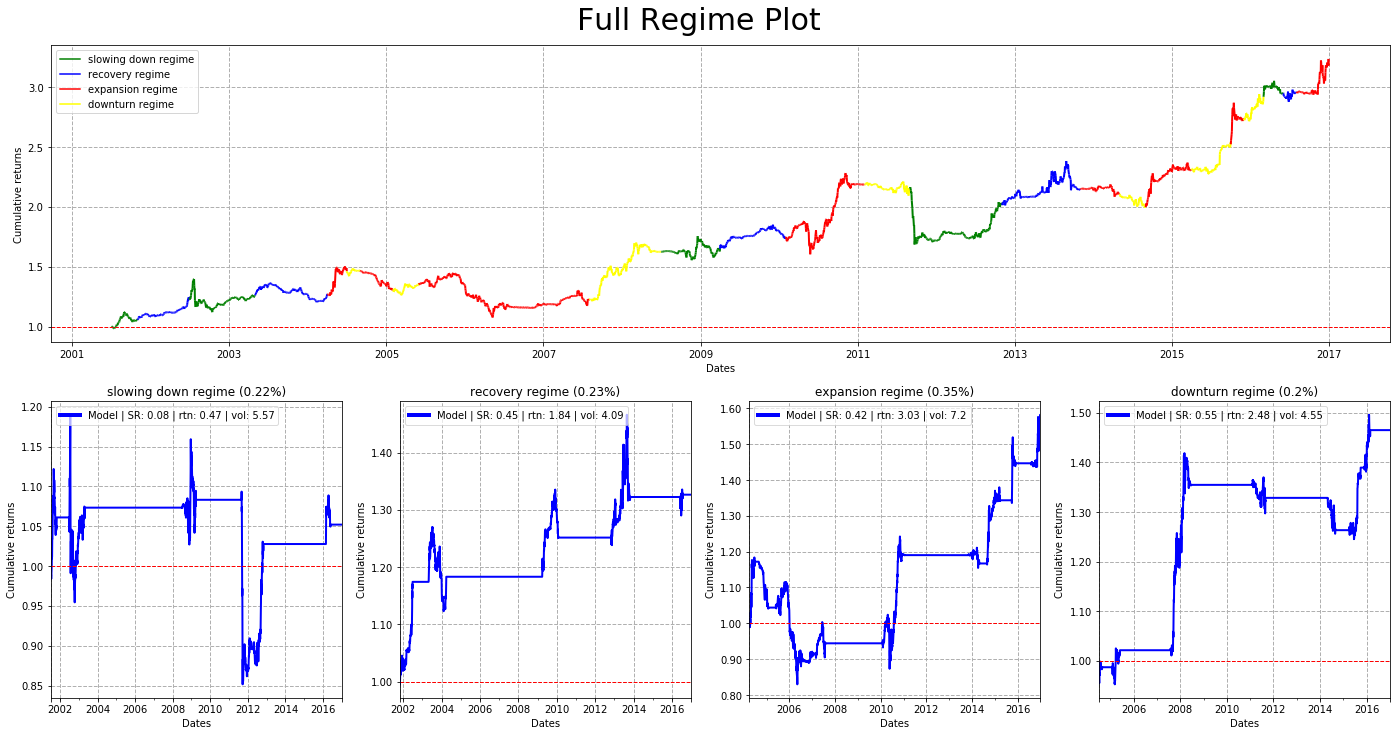

In [577]:
full_regime_plot(bt_obj, regime4)

## 5. Macroeconomic Framework
1. Inflationary: 2001-2003, 2007, 2010, 2011. Positive growth, high inflation (growth rate >0%, inflation >2% compared to previous year)
2. Stagflation: 2004-2006. Negative growth, high inflation (growth rate <0%, inflation >2% compared to previous year)
3. Recession: 2008-2009 (GFC). Negative growth, low inflation (growth rate <0%, inflation <2% compared to previous year)
4. Positive growth: 2012-2016. Disinflationary growth, low inflation (growth rate >0%, inflation <2% compared to previous year)

source: https://investmentsandwealth.org/getattachment/8e261442-e14c-4ab1-8388-e9462cc26d7c/IWM20JulAug-RegimeBasedAssetAllocation.pdf

In [653]:
regime5 = pd.DataFrame(bt_obj.model_rtn)
regime5['regime'] = np.where(regime5.index > datetime(2011,12,31), 'positive growth', 
                    np.where((regime5.index > datetime(2007,12,31)) & (regime5.index < datetime(2010,1,1)), 'recession',
                    np.where((regime5.index > datetime(2003,12,31)) & (regime5.index < datetime(2007,1,1)), 'stagflation','inflationary')))
                             
regime5 = regime5['regime']     
regime5

Dates
2001-07-03       inflationary
2001-07-04       inflationary
2001-07-05       inflationary
2001-07-06       inflationary
2001-07-09       inflationary
                   ...       
2016-12-26    positive growth
2016-12-27    positive growth
2016-12-28    positive growth
2016-12-29    positive growth
2016-12-30    positive growth
Name: regime, Length: 4044, dtype: object

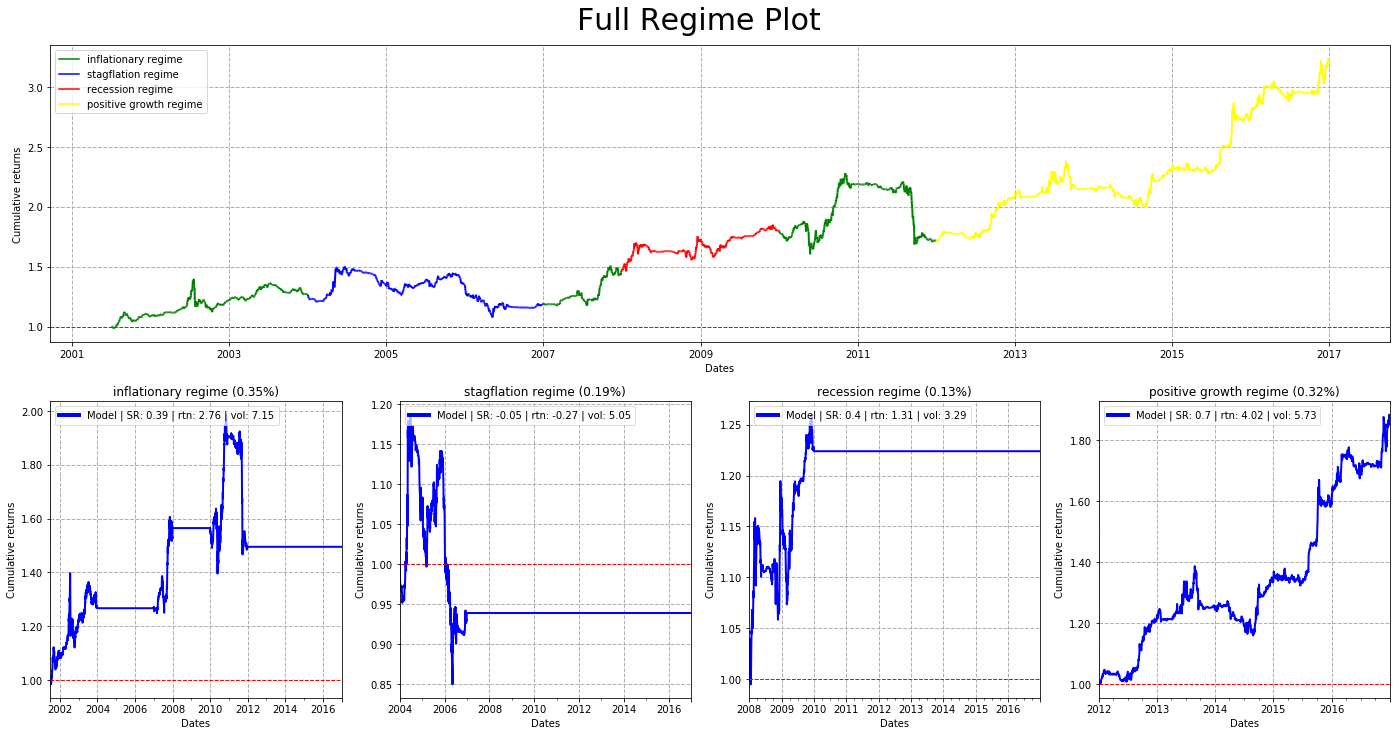

In [654]:
full_regime_plot(bt_obj, regime5)